# Zonal statistics for a stack of daily ET GeoTIFFs

## Initialize

### Import Libraries

import glob
from pathlib import Path
from typing import List, Sequence

import geopandas as gpd
import pandas as pd

import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterstats import zonal_stats

from tqdm.auto import tqdm   # nice progress bar in notebooks





### Define Functions

#### Zonal Statistics Functions

In [24]:

def _ensure_iterable(x: str | Sequence[str]) -> List[str]:
    """Turn a string like 'mean,sum' or a list into a clean list."""
    if isinstance(x, str):
        return [s.strip() for s in x.split(",") if s.strip()]
    return list(x)

def zonal_stats_daily(
    zones: gpd.GeoDataFrame,
    raster_dir: str | Path,
    pattern: str = "*.tif",
    stats: str | Sequence[str] = "mean",
    nodata: float | None = None,
    all_touched: bool = False,
    zone_id_col: str | None = None,
) -> pd.DataFrame:
    """
    Compute zonal statistics for every raster in `raster_dir` that matches `pattern`.

    Parameters
    ----------
    zones : GeoPackage (GeoPandas object).
    raster_dir : str or Path
        Folder containing daily ET rasters.
    pattern : str, default "*.tif"
        Glob pattern for rasters.
    stats : str or sequence, default "mean"
        Stats to calculate (comma-separated string or list).
        Examples: "mean,sum", ["mean", "count", "std"].
    nodata : float or None, default None
        NoData value to ignore.  If None, use the raster's internal NoData.
    all_touched : bool, default False
        If True, count any pixel the polygon touches; otherwise use pixel
        centres only (the rasterstats default).
    zone_id_col : str or None, default None
        Name of an existing column to act as unique zone key.
        If None, a new `zone_id` column will be created automatically.

    Returns
    -------
    pandas.DataFrame
        Columns: zone_id, date (from raster filename), <requested stats…>
    """

    raster_dir = Path(raster_dir).expanduser().resolve()
    tif_paths = sorted(raster_dir.glob(pattern))
    if not tif_paths:
        raise FileNotFoundError(f"No rasters match {raster_dir / pattern}")

    # Make sure there's a unique integer key
    key = zone_id_col or "zone_id"
    if key not in zones.columns:
        zones[key] = zones.index + 1

    stats_list = _ensure_iterable(stats)
    records = []

    for tif in tqdm(tif_paths, desc="Processing rasters"):
        date_label = tif.stem           # e.g. "20250601"
        with rasterio.open(tif) as src:
            r_crs = src.crs

        # Re-project polygons on-the-fly if CRS differs
        zones_local = zones if zones.crs == r_crs else zones.to_crs(r_crs)

        zs = zonal_stats(
            vectors=zones_local,
            raster=str(tif),
            stats=stats_list,
            nodata=nodata,
            all_touched=all_touched,
            geojson_out=False,
        )

        # Combine each polygon’s stats with its key & date
        for z_row, z_stat in zip(zones_local.itertuples(index=False), zs):
            rec = {"zone_id": getattr(z_row, key), "date": date_label}
            rec.update({s: z_stat.get(s) for s in stats_list})
            records.append(rec)

    return pd.DataFrame(records)


# -----------------------------------------------------------------
# EXAMPLE USE (uncomment & edit paths to try it in your notebook) :
# -----------------------------------------------------------------
# df = zonal_stats_daily(
#     gpkg="cottonwood_watersheds.gpkg",
#     layer="watersheds",
#     raster_dir="./daily_et",
#     pattern="*.tif",
#     stats="mean,sum",
#     all_touched=True,
# )
# df.head()


#### Reprojection Function

In [6]:

def reproject_raster(
    src_path: str | Path,
    dst_path: str | Path,
    dst_crs: str | dict,
    resampling: Resampling = Resampling.nearest,
    dst_resolution: tuple[float, float] | None = None,
) -> None:
    """
    Reproject a raster to a new coordinate reference system (CRS).

    Parameters
    ----------
    src_path : str or Path
        Path to the input raster (any GDAL-readable format).
    dst_path : str or Path
        Output path for the reprojected raster (extension chooses driver).
    dst_crs : str or dict
        Target CRS, e.g. "EPSG:32612" or a full PROJ string.
    resampling : rasterio.warp.Resampling, optional
        Resampling algorithm; default is nearest-neighbour.
    dst_resolution : (float, float) or None, optional
        Output pixel size (x_res, y_res) in target units.  If None,
        rasterio picks defaults that preserve total extent.
    """
    src_path, dst_path = Path(src_path), Path(dst_path)

    with rasterio.open(src_path) as src:
        transform, width, height = calculate_default_transform(
            src.crs, dst_crs, src.width, src.height, *src.bounds,
            resolution=dst_resolution
        )
        profile = src.profile.copy()
        profile.update(
            crs=dst_crs,
            transform=transform,
            width=width,
            height=height
        )

        # Create folders if needed
        dst_path.parent.mkdir(parents=True, exist_ok=True)

        with rasterio.open(dst_path, "w", **profile) as dst:
            for i in range(1, src.count + 1):
                reproject(
                    source=rasterio.band(src, i),
                    destination=rasterio.band(dst, i),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=transform,
                    dst_crs=dst_crs,
                    resampling=resampling,
                )



### Set Directories

In [16]:
gis_dir = Path("E:/UGS_Flux/Projects_and_Proposals/Castledale_ET/GIS")
rast_dir = gis_dir / "ECOSTRESS"
raw_rast_dir = rast_dir / "raw"
repro_rast_dir = rast_dir / "reprojected"

## Import Geopackaage

EPSG:26912


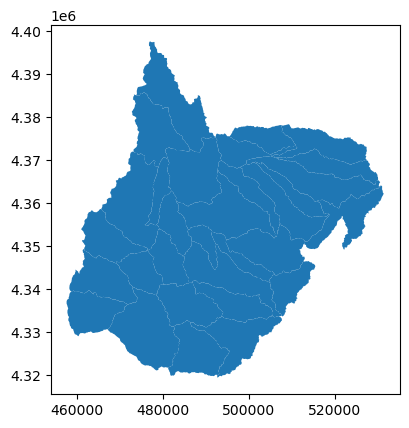

In [19]:
sheds = gpd.read_file(gis_dir / "cottonwood_watersheds.gpkg")
sheds.plot()
print(sheds.crs)

## Reproject Rasters

### ALEXI Daily

In [21]:


for file in raw_rast_dir.glob("*ALEXI_ETdaily*.tif"):
    yeardoy = str(file.stem).split("_")[-2][3:-6]
    year = int(yeardoy[:4])
    doy = int(yeardoy[-3:])
    print(year, doy)
    reproject_raster(file, repro_rast_dir / f"ecostress_ALEXI_{yeardoy}.tif",dst_crs = sheds.crs)

2019 147
2019 151
2019 154
2019 158
2019 159
2019 161
2019 162
2019 163
2019 165
2019 169
2019 172
2019 172
2019 173
2019 173
2019 176
2019 176
2019 180
2019 180
2019 183
2019 184
2019 187
2019 187
2019 213
2019 223
2019 224
2019 225
2019 231
2019 243
2019 246
2019 250
2019 250
2019 269
2019 272
2019 280
2019 287
2019 288
2019 291
2019 291
2019 292
2019 292
2019 295
2019 295
2019 299
2019 299
2019 307
2019 307
2019 340
2019 344
2019 348
2020 26
2020 29
2021 91
2021 92
2021 96
2021 97
2021 99
2021 103
2021 103
2021 104
2021 104
2021 107
2021 108
2021 108
2021 124
2021 131
2021 140
2021 144
2021 147
2021 155
2021 156
2021 159
2021 175
2021 175
2021 187
2021 191
2021 234
2021 234
2021 235
2021 239
2021 243
2021 247
2021 267
2021 267
2021 270
2021 270
2021 271
2021 271
2021 283
2021 283
2021 283
2021 286
2021 286
2021 287
2021 287
2021 290
2021 295
2021 299
2021 334
2021 335
2021 335
2021 342
2021 342
2022 28
2022 32
2022 35
2022 36
2022 82
2022 86
2022 89
2022 90
2022 93
2022 108
2022 109

### JPL

## Zonal Statistics

In [33]:
df = zonal_stats_daily(sheds,
    raster_dir=repro_rast_dir,
    pattern = "*ALEXI*.tif")

Processing rasters:   0%|          | 0/115 [00:00<?, ?it/s]

In [35]:
# 1. Split on '_' and grab the last part (year + day‑of‑year)
df["year_doy"] = df["date"].str.split("_").str[-1]

# 2. Convert that YYYYDOY string (e.g. 2019147) to a real datetime
df["parsed_date"] = pd.to_datetime(df["year_doy"], format="%Y%j")

# 3. Keep the year and DOY as separate numeric columns
df["year"] = df["parsed_date"].dt.year
df["doy"] = df["parsed_date"].dt.dayofyear

dfind = df.set_index(['zone_id','parsed_date'])

<Axes: xlabel='parsed_date'>

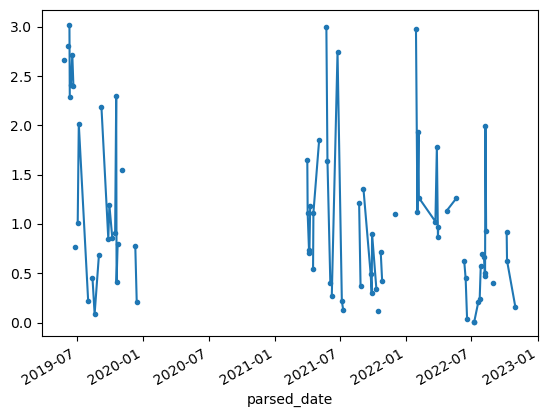

In [41]:
dfind.loc[1,'mean'].plot(marker=".")